In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pickle as pkl
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr, spearmanr
import itertools as it

In [2]:
prefix = '/data/codec/'

Read in the pseudobulked counts, and just change the `FID` column to `IND`, which is a better descriptor.

In [3]:
pseudobulk = pd.read_pickle(prefix + 'production.run/mrna/pkls/aggr/pseudobulk.conds.inds.pkl')
pseudobulk.columns = [pseudobulk.columns.tolist()[0]] + ['IND'] + pseudobulk.columns.tolist()[2:]

Read in the bulk, and adjust it to match the pseudobulk.

In [4]:
bulk = pd.read_pickle(prefix + 'bulk.jan20/counts.pkl')

# only get the raw values from timepoint 9, which is what we probably want to compare to
bulk = bulk['raw'][bulk['raw'].index.get_level_values('TIME') == '9']

# flatten the multi-index, were those ever a good idea?
bulk.reset_index(inplace=True)

# drop the time column and the last 5 which have some metadata
bulk.drop(columns=['TIME'] + bulk.columns.tolist()[-5:], inplace=True)

# rename the `STIM` column as `COND`
bulk.columns = ['IND', 'COND'] + bulk.columns.tolist()[2:]

# make the condition names match
cond_dict = {'TNFa': 'A',
             'R848': 'R',
             'PMAI': 'P',
             'IFNG': 'G',
             'IFNB': 'B',
             'Control': 'C'
            }
for long_cond in cond_dict:
    bulk['COND'] = bulk['COND'].str.replace(long_cond,cond_dict[long_cond])

In [5]:
print(pseudobulk.shape)
print(bulk.shape)

(384, 20305)
(18, 33540)


Pseudobulk has one row that has all zeros; one of the individuals (#10) had very few cells across all conditions, but apparently has 0 cells in the `B` condition.

In [6]:
print(pseudobulk.iloc[66][:2].values)
print(pseudobulk.iloc[66].values[2:].sum())

['B' '10']
0.0


In [7]:
pseudobulk = pseudobulk.loc[pseudobulk.iloc[:,2:].sum(1) > 0,:]

The bulk dataset has some duplicate genes. As I did with the input to DESeq2, I'm just summing over these duplicate columns.

In [8]:
cols, counts_of_cols = np.unique(bulk.columns.values, return_counts=True)   

for dup_gene in cols[counts_of_cols > 1]: # the columns also contain some meta data, but none of those should be repeated
    new_vals = bulk[dup_gene].sum(axis=1)
    bulk.drop(dup_gene, axis=1, inplace=True)
    bulk[dup_gene] = new_vals # note these get added to the end, not in their original place, but it shouldn't matter

Normalize per patient-condition, and log?:

In [9]:
bulk_data = csr_matrix(bulk.iloc[:,2:].values.astype(np.float128))

In [10]:
pseudobulk_data = csr_matrix(pseudobulk.iloc[:,2:].values.astype(np.float128))

In [11]:
# pseudobulk_data = np.array(np.log1p(pseudobulk_data/pseudobulk_data.sum(1)))
# bulk_data = np.array(np.log1p(bulk_data/bulk_data.sum(1)))

pseudobulk_data = np.array(pseudobulk_data/pseudobulk_data.sum(1))*1e6
bulk_data = np.array(bulk_data/bulk_data.sum(1))*1e6

In [12]:
print(pseudobulk_data.shape)
print(bulk_data.shape)

(383, 20303)
(18, 33514)


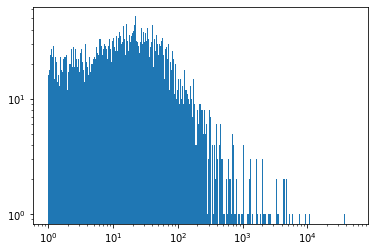

In [13]:
# plt.hist(pseudobulk_data.mean(0), bins=100);
plt.hist(pseudobulk_data.mean(0), bins=np.logspace(np.log10(1), np.log10(50000), 1000));
plt.yscale('log')
plt.xscale('log')

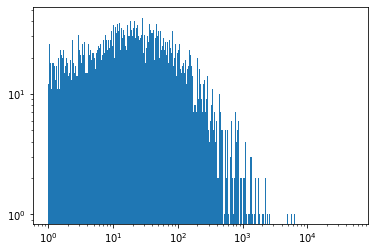

In [14]:
# plt.hist(bulk_data.mean(0), bins=100);
plt.hist(bulk_data.mean(0), bins=np.logspace(np.log10(1), np.log10(50000), 1000));
plt.yscale('log')
plt.xscale('log')

In [15]:
pseudobulk_data.mean(0).shape

(20303,)

In [16]:
pseudobulk_keep = (pseudobulk_data.sum(0) > 0)
pseudobulk_data = pseudobulk_data[:,pseudobulk_keep].copy()
pseudobulk = pseudobulk.iloc[:,[True, True] + pseudobulk_keep.tolist()].copy()

In [17]:
bulk_keep = (bulk_data.sum(0) > 0)
bulk_data = bulk_data[:,bulk_keep].copy()
bulk = bulk.iloc[:,[True, True] + bulk_keep.tolist()].copy()

In [18]:
print(pseudobulk_data.shape)
print(bulk_data.shape)

(383, 20303)
(18, 20425)


In [19]:
bulk = bulk[['COND', 'IND']].join(pd.DataFrame(data=bulk_data, columns=bulk.columns[2:], index=bulk.index))
pseudobulk = pseudobulk[['COND', 'IND']].join(pd.DataFrame(data=pseudobulk_data, columns=pseudobulk.columns[2:], index=pseudobulk.index))

In [20]:
print(bulk.shape)
print(pseudobulk.shape)

(18, 20427)
(383, 20305)


In [26]:
prefix

'/data/codec/'

In [27]:
# with open(prefix + 'production.run/mrna/pkls/aggr/pseuobulk.conds.inds.norm.pkl', 'wb') as file:
#     pkl.dump(pseudobulk, file)
# with open(prefix + 'bulk.jan20/counts.norm.pkl', 'wb') as file:
#     pkl.dump(bulk, file)

In [28]:
with open(prefix + 'production.run/mrna/pkls/aggr/pseuobulk.conds.inds.norm.pkl', 'rb') as file:
    pseudobulk = pkl.load(file)
with open(prefix + 'bulk.jan20/counts.norm.pkl', 'rb') as file:
    bulk = pkl.load(file)

In [21]:
# file_path = prefix + 'production.run/mrna/var/de_union.genes.txt'
# with open(file_path, 'r') as file:
#     de_union = [i.strip() for i in file.readlines()]

In [22]:
bulk_genes = bulk.columns[2:].values
pseudobulk_genes = pseudobulk.columns[2:].values
common_genes = np.intersect1d(bulk_genes, pseudobulk_genes)
# common_genes = np.intersect1d(common_genes, np.array(de_union))

In [23]:
bulk = bulk[['COND', 'IND'] + list(common_genes)].sort_values(['COND','IND'])
pseudobulk = pseudobulk[['COND', 'IND'] + list(common_genes)]

In [24]:
print(bulk.shape)
print(pseudobulk.shape)

(18, 18376)
(383, 18376)


In [25]:
conds = np.array(list(cond_dict.values()))
genes = bulk.columns[2:].values

In [26]:
bulk_cond_means = pd.DataFrame(0, index=conds, columns=genes)
pseudobulk_cond_means = pd.DataFrame(0, index=conds, columns=genes)

In [27]:
for cond in tqdm(conds):
    bulk_cond_means.loc[cond] = bulk.loc[bulk['COND'] == cond, genes].mean(axis=0) + 1
    pseudobulk_cond_means.loc[cond] = pseudobulk.loc[pseudobulk['COND'] == cond, genes].mean(axis=0) + 1

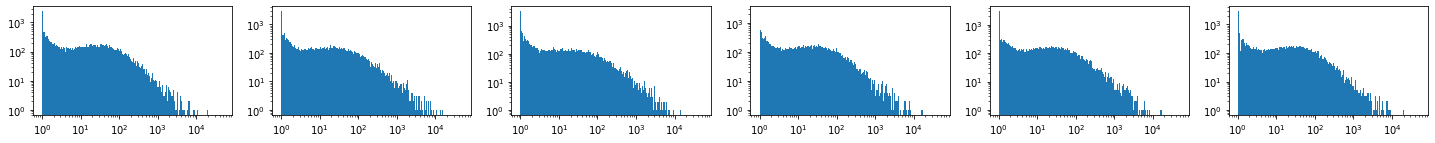

In [28]:
fig, ax = plt.subplots(1, 6, figsize=(25,2))
for cond, ax in zip(conds, ax):
    ax.hist(bulk_cond_means.loc[cond].values, bins=np.logspace(np.log10(1), np.log10(50000), 200));
    ax.set_yscale('log')
    ax.set_xscale('log')

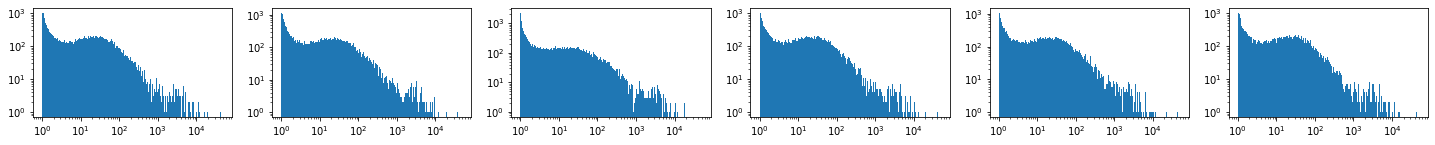

In [29]:
fig, ax = plt.subplots(1, 6, figsize=(25,2))
for cond, ax in zip(conds, ax):
    ax.hist(pseudobulk_cond_means.loc[cond].values, bins=np.logspace(np.log10(1), np.log10(50000), 200));
    ax.set_yscale('log')
    ax.set_xscale('log')

In [39]:
b_keep_genes = dict()
p_keep_genes = dict()
for cond in conds:
    b_keep_genes[cond] = bulk_cond_means.columns[bulk_cond_means.loc[cond] >= 5].values
    p_keep_genes[cond] = pseudobulk_cond_means.columns[pseudobulk_cond_means.loc[cond] >= 5].values

In [32]:
bulk_cond = bulk_cond_means.copy()
pseudobulk_cond = bulk_cond_means.copy()

In [33]:
for cond in conds[conds != 'C']:
    bulk_cond.loc[cond] = np.divide(bulk_cond_means.loc[cond].values, bulk_cond_means.loc['C'].values)
    pseudobulk_cond.loc[cond] = np.divide(pseudobulk_cond_means.loc[cond].values, pseudobulk_cond_means.loc['C'].values)

In [34]:
bulk_cond = np.log2(bulk_cond)
pseudobulk_cond = np.log2(pseudobulk_cond)

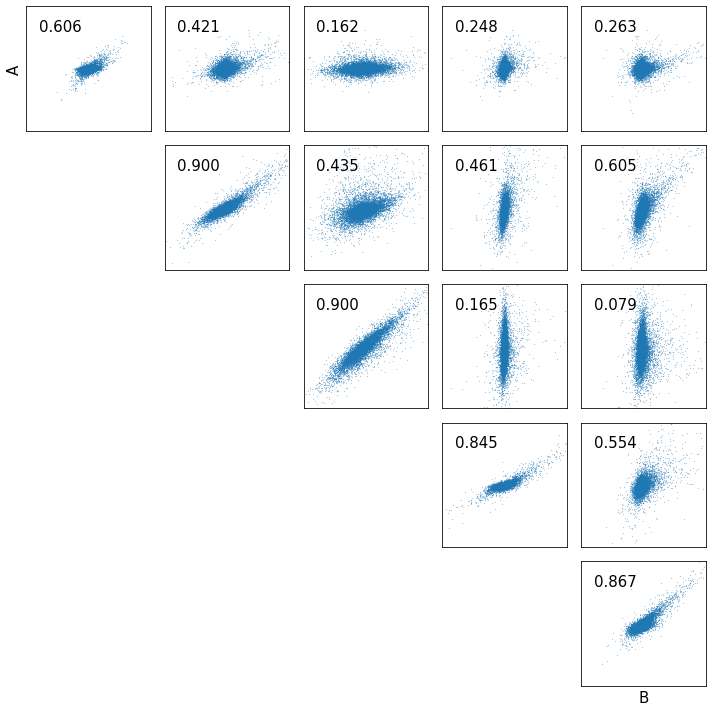

In [61]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for pair_cond, pair_plot in zip(it.product(conds[conds != 'C'], repeat=2), it.product(range(5), repeat=2)):
    c0, c1 = pair_cond
    p0, p1 = pair_plot
    
    common_genes = np.intersect1d(b_keep_genes[c0], p_keep_genes[c1])
    b = bulk_cond.loc[c0, common_genes].values
    p = pseudobulk_cond.loc[c1, common_genes].values
    if p1 < p0:
        ax[p0, p1].set_visible(False)
    else:
        if p1 == 0:
            ax[p0, p1].set_ylabel(c0, fontdict={'fontsize':15})
        if p0 == 4:
            ax[p0, p1].set_xlabel(c1, fontdict={'fontsize':15})
        if p0 != p1:
            ax[p0, p1].scatter(p, b, s=0.02)
        else:
            ax[p0, p1].scatter(b, p, s=0.02)
        ax[p0, p1].text(0.1, 0.8, str(pearsonr(b, p)[0])[:5], transform=ax[p0, p1].transAxes, horizontalalignment='left', fontdict={'fontsize':15})
#         ax[p0, p1].text(0.1, 0.8, str((c0 + 'b', c1 + 'p')), transform=ax[p0, p1].transAxes, horizontalalignment='left', fontdict={'fontsize':15})
        ax[p0, p1].set_xlim((-5, 5))
        ax[p0, p1].set_ylim((-5, 5)) 
        ax[p0, p1].set_xticks([])
        ax[p0, p1].set_yticks([])
            
#         ax[p0, p1].hist2d(b, p, bins=50)

plt.tight_layout()

## ^^^^_SOMETHING HERE SEEMS OFF_^^^^
_DISTRIBUTIONS IN SCATTER PLOT PROJECTED ON EITHER AXIS SHOULDN'T CHANGE FROM PLOT TO PLOT, BUT THEY LOOK LIKE THEY DO_
_COULD IT BE DUE TO THE DIFFERENT GENE SETS I'M USING FOR EACH COMPARISON? OR AM I FUCKING UP THE CROSS PRODUCT AND INDEXING?_

# EXTRA

In [189]:
df = pd.DataFrame(0, index=conds, columns=conds)

In [190]:
for c1, c2 in it.combinations(conds, r=2):
    df.loc[c2, c1] = spearmanr(mean_vals['b'][c1], mean_vals['p'][c2])[0]

In [191]:
for c1 in conds:
    df.loc[c1, c1] = spearmanr(mean_vals['b'][c1], mean_vals['p'][c1])[0]

In [192]:
mask = np.zeros_like(df, dtype=np.bool)

In [193]:
mask[np.triu_indices_from(mask, k=1)] = True

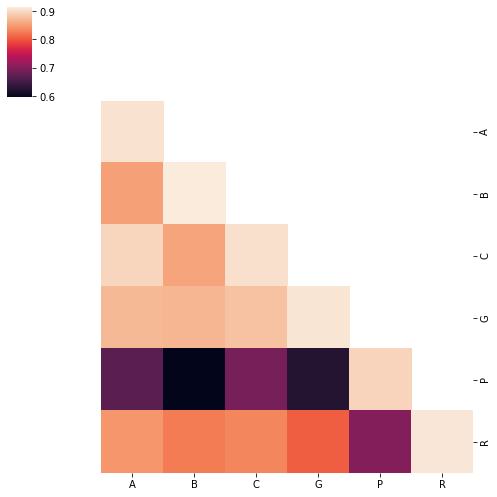

In [194]:
# plt.figure(figsize=(7,7))
sns.clustermap(df, mask=mask, col_cluster=False, row_cluster=False, figsize=(7,7));
# sns.heatmap(df, mask=mask, square=True)

In [195]:
def standard_triangle(input_arr):
    arr = input_arr.copy()
    assert arr.shape[0] == arr.shape[1]
    dim = arr.shape[0]
    
    mask = np.zeros_like(arr, dtype=np.bool)
    mask[np.triu_indices_from(arr, k=1)] = True
    assert all(arr[mask] == False)
    
    raveled = arr.ravel().copy()
    for i, j in tqdm(it.combinations_with_replacement(range(arr.shape[0]), r=2)):
        vals_with_zeros = raveled[[any([k, m]) for k, m in it.product(np.arange(dim) == j, np.arange(dim) == i)]]
        vals_nonzero = vals_with_zeros[vals_with_zeros != 0]
        ind = (vals_nonzero == arr[j, i]).argmax()
        vals_nonzero = (vals_nonzero - min(vals_nonzero))
        vals_nonzero = vals_nonzero/vals_nonzero.max()
        arr[j, i] = vals_nonzero[ind]
    return arr

In [196]:
arr = df.values.copy()

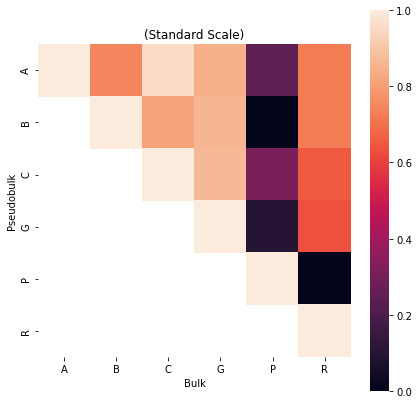

In [198]:
plt.figure(figsize=(7,7))
sns.heatmap(pd.DataFrame(standard_triangle(arr), index=df.index, columns=df.columns).T, mask=mask.T, square=True)
plt.title('(Standard Scale)')
plt.ylabel('Pseudobulk')
plt.xlabel('Bulk');

In [182]:
diagonal = df.values.diagonal()

In [183]:
non_diagonal_with_nans = df.mask(np.equal(*np.indices(df.shape))).values.flatten()
non_diagonal = np.unique(non_diagonal_with_nans[~np.isnan(non_diagonal_with_nans)])

In [184]:
df_compare = pd.DataFrame(data=list(zip(['SAME']*len(diagonal),
                           diagonal)) + 
             list(zip(['DIFF']*len(non_diagonal),
                      non_diagonal)), columns=['COMPARISON', 'SPEARMANR'])

(0.8, 1.0)

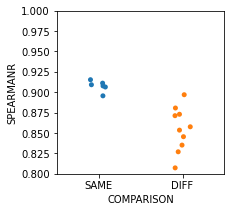

In [185]:
plt.figure(figsize=(3,3))
sns.stripplot(data=df_compare, x='COMPARISON', y='SPEARMANR');
plt.ylim(0.8, 1)

In [122]:
df_compare

,COMPARISON,SPEARMANR
0,SAME,0.924011
1,SAME,0.925376
2,SAME,0.922699
3,SAME,0.924494
4,SAME,0.918298
5,SAME,0.924814
6,DIFF,0.838307
7,DIFF,0.843448
8,DIFF,0.849876
9,DIFF,0.851518
